## final project submission

Please fill out:
* Student name: Claire Sarraille
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor




%matplotlib inline

## crisp-dm:

- Business Understanding
    - Who will be  using the model
    - How will the model be used
    - How will using the model help our business
    - clarify requirements
    - What problems are in and out of scope

- Understand Data
    - What is target
    - What are predictors
    - Distribution of Data
    - How many observations - and is this a small, medium or large collection?
    - What is the quality? - What errors could be in the data, or inaccuracy?

- Data Preparation - Prepping to model
    - Missing values
    - Type conversions
    - Remove multicollinearity (correlated predictors)
    - Normalize numeric data
    - Convert categorical data to numeric via one-hot encoding

- Modeling:
    - Tune models to get the highest performance possible on our task
    - Considerations:
        - What kind of task? Classification task? Regression task?
        - Which models will we use
        - Will be use regularization?
        - How will we validate our model?
        - Loss functions?
        - What is the performance threshold for success?

- Evaluation:
    - Does the model solve business problem outlined in step 1?
    - At this point, we may want to start over at the business understanding step, now that we have a deeper understanding
    - Things we may learn at this stage:
        - Need different data
        - Need more data
        - Should be going in a different direction
        - Should use classificaion rather than regression, or vice versa
        - Use different approach

- Deployment:
    - Move the model into production
    - Set up ETL - how much of preprocessing and cleaning can be automated?


# BUSINESS UNDERSTANDING
- Who will be  using the model
    - The real estate agency I work for
- How will the model be used
    - Help home owners buy and/or sell homes
- How will using the model help our business
    - We can give good advice to homeowners about how home renovations might increase the estimate value of their homes, and by how much
- clarify requirements
    - Find the features that are highest correlated with a higher sell price. Find how many dollars each unit of each feature adds to price
    - Use these correlations to recommend home renovations, ranked by the most to least positive impact on price.
- What problems are in and out of scope
    - How do home renovations impact the sell price of a home.
    - We are not looking at other factors, such as location (waterfront), which the owner can't renovate the house to have.

In [79]:
# Read in Data:
df = pd.read_csv('data/kc_house_data.csv')

## Remove features
- id ( we don't want our model thinking that id has explanatory power since we know it has nothing to do with price)
- date (same for date - no explanatory value)
- view (this is repeating info from waterfront)
- sqft_above (repeating sqft_living)
- sqft_basemenat (repeating sqft_living)
- yr_renovated (repeating yr_built)
- Not helpful to have geographic features becuase renovation can't inclue re-locating house (ostensibly)
    - zipcode
    - lat
    - long
- sqft_living15 (repeating sqft_living)
- sqft_lot15 (repeating sqft_lot)

In [80]:
# Why reduce features?
# I narrowed my list of features so that I could avoid overfitting the training dataset
# Reducing redundancy in features increases the accuracy of the model
# I also removed 'id' because this field  has little to no predictive value

df = df.drop(['id','date','view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1)

In [81]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1955
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987


# UNDERSTAND DATA
- What is target
    - price
- What are predictors
    - sqft_living, bathrooms, bedrooms, floors, sqft_lot, condition
- Distribution of Data
- How many observations - and is this a small, medium or large collection?
    - 21,597 entries
    - According to Frank Harrell in his book Regression Modeling Strategies, you need at least 10-20 observations per predictor
    - We have many, many more observations than 20 * (6 - num covariates) = 120
    - Our dataset would be considered large
- What is the quality? - What errors could be in the data, or inaccuracy?

## New Columns 

In [82]:
# Create lot size in acres:
df['acres_lot'] = df['sqft_lot'] / 43560 

In [83]:
# Create price column in millions:
df['price_millions'] = df['price'] / 1000000

In [84]:
df[['price_millions','price', 'acres_lot']]

,price_millions,price,acres_lot
0,0.221900,221900.0,0.129706
1,0.538000,538000.0,0.166253
2,0.180000,180000.0,0.229568
3,0.604000,604000.0,0.114784
4,0.510000,510000.0,0.185491
...,...,...,...
21592,0.360000,360000.0,0.025964
21593,0.400000,400000.0,0.133448
21594,0.402101,402101.0,0.030992
21595,0.400000,400000.0,0.054821


In [85]:
print(f"The max price is {df['price_millions'].max()} million, min price is {df['price'].min()}")

The max price is 7.7 million, min price is 78000.0


## Price Frequency Histogram

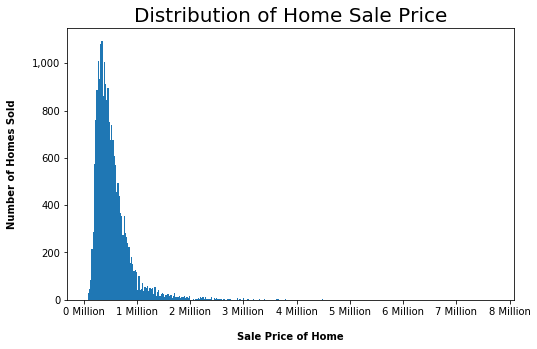

In [88]:
ax = df.hist(column='price_millions',
             bins='auto',
             grid=False,
             figsize=(8,5))

ax = ax[0]
for x in ax:

    x.set_title("Distribution of Home Sale Price", size=20)

    # Set x-axis label
    x.set_xlabel("Sale Price of Home", labelpad=15, weight='bold', size=10)
    x.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}' + ' Million'))

    # Set y-axis label
    x.set_ylabel("Number of Homes Sold", labelpad=15, weight='bold', size=10)
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


## Quality - Possible Errors

- There could be outliers - such as hundreds of bathrooms - which doesn't make sense with square footage
- Year could be in the future
- price could be a negative number
- datatype could be wrong - such as string for number of bedrooms

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           21597 non-null  float64
 1   bedrooms        21597 non-null  int64  
 2   bathrooms       21597 non-null  float64
 3   sqft_living     21597 non-null  int64  
 4   sqft_lot        21597 non-null  int64  
 5   floors          21597 non-null  float64
 6   waterfront      19221 non-null  float64
 7   condition       21597 non-null  int64  
 8   grade           21597 non-null  int64  
 9   yr_built        21597 non-null  int64  
 10  acres_lot       21597 non-null  float64
 11  price_millions  21597 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 2.0 MB


In [90]:
# The only field that I retained containing NaN values is waterfront:
df.isnull().sum()

price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront        2376
condition            0
grade                0
yr_built             0
acres_lot            0
price_millions       0
dtype: int64

## Outliers using IQR
- I'm not sure if I'll need to drop outliers
- Nonetheless it was interesting to see where the extreme outliers are located.

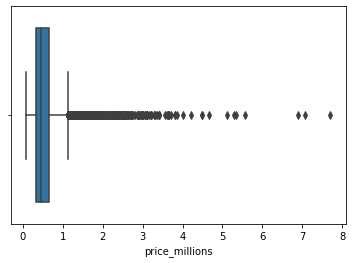

In [91]:
sns.boxplot(x=df['price_millions'])


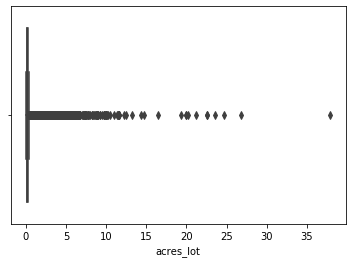

In [14]:
sns.boxplot(x=df['acres_lot'])


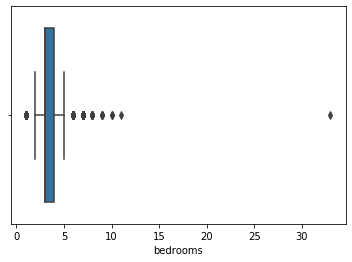

In [15]:
sns.boxplot(x=df['bedrooms'])


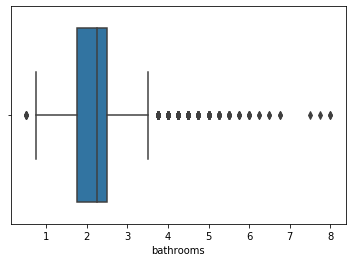

In [16]:
sns.boxplot(x=df['bathrooms'])


## Outliers using Sorting

In [93]:
df.sort_values('price_millions', ascending = False).head(100)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
7245,7700000.0,6,8.00,12050,27600,2.5,0.0,4,13,1910,0.633609,7.70
3910,7060000.0,5,4.50,10040,37325,2.0,1.0,3,11,1940,0.856864,7.06
9245,6890000.0,6,7.75,9890,31374,2.0,0.0,3,13,2001,0.720248,6.89
4407,5570000.0,5,5.75,9200,35069,2.0,0.0,3,13,2001,0.805073,5.57
1446,5350000.0,5,5.00,8000,23985,2.0,0.0,3,12,2009,0.550620,5.35
...,...,...,...,...,...,...,...,...,...,...,...,...
3018,2530000.0,4,5.50,6930,45100,1.0,0.0,4,11,1950,1.035354,2.53
17544,2510000.0,3,3.25,5480,57990,2.0,1.0,3,11,1991,1.331267,2.51
7304,2500000.0,4,4.00,3330,24354,1.0,0.0,4,10,1961,0.559091,2.50
17137,2500000.0,4,3.75,3480,14850,1.0,NaN,3,9,1951,0.340909,2.50


In [18]:
df.sort_values('bedrooms', ascending = False).head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
15856,640000.0,33,1.75,1620,6000,1.0,0.0,5,7,1947,0.137741,0.640000
8748,520000.0,11,3.00,3000,4960,2.0,0.0,3,7,1918,0.113866,0.520000
13301,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2008,0.250689,1.150000
19239,660000.0,10,3.00,2920,3745,2.0,0.0,4,7,1913,0.085973,0.660000
15147,650000.0,10,2.00,3610,11914,2.0,0.0,4,7,1958,0.273508,0.650000
6073,1280000.0,9,4.50,3650,5000,2.0,0.0,3,8,1915,0.114784,1.280000
4231,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,1908,0.101010,0.700000
16830,1400000.0,9,4.00,4620,5508,2.5,0.0,3,11,1915,0.126446,1.400000
8537,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,1996,0.149311,0.450000
4092,599999.0,9,4.50,3830,6988,2.5,0.0,3,7,1938,0.160422,0.599999


In [19]:
df.sort_values('bathrooms', ascending = False).head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
12764,2280000.0,7,8.00,13540,307752,3.0,0.0,3,12,1999,7.065014,2.28
7245,7700000.0,6,8.00,12050,27600,2.5,0.0,4,13,1910,0.633609,7.70
9245,6890000.0,6,7.75,9890,31374,2.0,0.0,3,13,2001,0.720248,6.89
8537,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,1996,0.149311,0.45
4020,800000.0,7,6.75,7480,41664,2.0,0.0,3,11,1953,0.956474,0.80
8085,4670000.0,5,6.75,9640,13068,1.0,1.0,3,12,1983,0.300000,4.67
20562,1180000.0,6,6.50,6260,10955,2.0,NaN,3,11,2007,0.251492,1.18
21490,2240000.0,5,6.50,7270,130017,2.0,0.0,3,12,2010,2.984780,2.24
14542,2890000.0,5,6.25,8670,64033,2.0,0.0,3,13,1965,1.469995,2.89
18288,3300000.0,5,6.25,8020,21738,2.0,0.0,3,11,2001,0.499036,3.30


In [20]:
df.sort_values('sqft_living', ascending = False).head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
12764,2280000.0,7,8.00,13540,307752,3.0,0.0,3,12,1999,7.065014,2.28
7245,7700000.0,6,8.00,12050,27600,2.5,0.0,4,13,1910,0.633609,7.70
3910,7060000.0,5,4.50,10040,37325,2.0,1.0,3,11,1940,0.856864,7.06
9245,6890000.0,6,7.75,9890,31374,2.0,0.0,3,13,2001,0.720248,6.89
8085,4670000.0,5,6.75,9640,13068,1.0,1.0,3,12,1983,0.300000,4.67
4407,5570000.0,5,5.75,9200,35069,2.0,0.0,3,13,2001,0.805073,5.57
14542,2890000.0,5,6.25,8670,64033,2.0,0.0,3,13,1965,1.469995,2.89
18288,3300000.0,5,6.25,8020,21738,2.0,0.0,3,11,2001,0.499036,3.30
1162,5110000.0,5,5.25,8010,45517,2.0,1.0,3,12,1999,1.044927,5.11
1446,5350000.0,5,5.00,8000,23985,2.0,0.0,3,12,2009,0.550620,5.35


In [21]:
df.sort_values('acres_lot', ascending = False).head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
1717,700000.0,4,1.00,1300,1651359,1.0,0.0,4,6,1920,37.909986,0.7000
17305,190000.0,2,1.00,710,1164794,1.0,0.0,2,5,1915,26.739991,0.1900
7640,542500.0,5,3.25,3010,1074218,1.5,NaN,5,8,1931,24.660652,0.5425
7762,855000.0,4,3.50,4030,1024068,2.0,0.0,3,10,2006,23.509366,0.8550
3945,998000.0,4,3.25,3770,982998,2.0,0.0,3,10,1992,22.566529,0.9980
4437,790000.0,2,3.00,2560,982278,1.0,0.0,3,8,2004,22.550000,0.7900
6685,2000000.0,2,2.50,3900,920423,2.0,0.0,3,12,2009,21.130005,2.0000
7070,1650000.0,4,3.25,3920,881654,3.0,NaN,3,11,2002,20.239991,1.6500
9705,937500.0,4,4.00,5545,871200,2.0,0.0,3,11,2003,20.000000,0.9375
20436,1600000.0,4,5.50,6530,871200,2.0,0.0,3,11,2008,20.000000,1.6000


## Descriptive Statistics Table

In [22]:
format_dict = {'bedrooms' : '{:.2f}', 'bathrooms' : '{:.2f}', 'floors' : '{:.2f}', 'sqft_living' : '{:20,.2f}', 'sqft_lot' : '{:20,.2f}', 'acres_lot' : '{:.2f}',  'price' : '${:20,.0f}', 'yr_built' : '{:.0f}'}
df[['price', 'yr_built', 'bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot', 'acres_lot']].describe().style.format(format_dict)

,price,yr_built,bedrooms,bathrooms,floors,sqft_living,sqft_lot,acres_lot
count,"$ 21,597",21597,21597.00,21597.00,21597.00,"21,597.00","21,597.00",21597.00
mean,"$ 540,297",1971,3.37,2.12,1.49,"2,080.32","15,099.41",0.35
std,"$ 367,368",29,0.93,0.77,0.54,918.11,"41,412.64",0.95
min,"$ 78,000",1900,1.00,0.50,1.00,370.00,520.00,0.01
25%,"$ 322,000",1951,3.00,1.75,1.00,"1,430.00","5,040.00",0.12
50%,"$ 450,000",1975,3.00,2.25,1.50,"1,910.00","7,618.00",0.17
75%,"$ 645,000",1997,4.00,2.50,2.00,"2,550.00","10,685.00",0.25
max,"$ 7,700,000",2015,33.00,8.00,3.50,"13,540.00","1,651,359.00",37.91


## Interpret Descriptive Statistics
- There are no negative values for any of the columns
- The year range makes sense: homes were built between 1900 and 2015
- sqft_living average is around 2,000, which is close to the US average
- The average lot size is 15,099 square feet, or .35 acres
- The lot size mean is skewed by our outlier home, which stands on a 37.91 acre lot.
- The median sqft_lot size is 7,618 or .17 acres, which is much closer to the national average of 0.188 of an acre.

# DATA PREPARATION
- Prepping to model
- Missing values
- Convert categorical data to numeric via one-hot encoding (we didn't need to do this)
- Type conversions (this was done in the previous section - price to millions and sqft to acres)
- Remove multicollinearity (correlated predictors)
- Normalize numeric data


## Waterfront Missing Values 
I filled in NaN values for 'waterfront' with 0. Now, 'waterfront' has a 1 value if there is a view, and 0 value if there is not.
I also cast this column as an integer type since there are no other options besides the integers 1 and 0.

In [23]:
df['waterfront'] = df['waterfront'].fillna(0)

In [24]:
df['waterfront'] = df["waterfront"].astype(int)

In [25]:
# Note: waterfront is our only categorical value.
# We don't need to use dummy coding or any other coding system because it's already dichotomous (1 or 0) 
df['waterfront'].unique()

array([0, 1])

## Pickle Save

## Scatter Matrix Distribution

In [28]:
# Select a subset of columns to create matrix:
df_scatter = df.drop(['price','condition','sqft_lot','waterfront','grade','yr_built', 'floors'], axis=1)

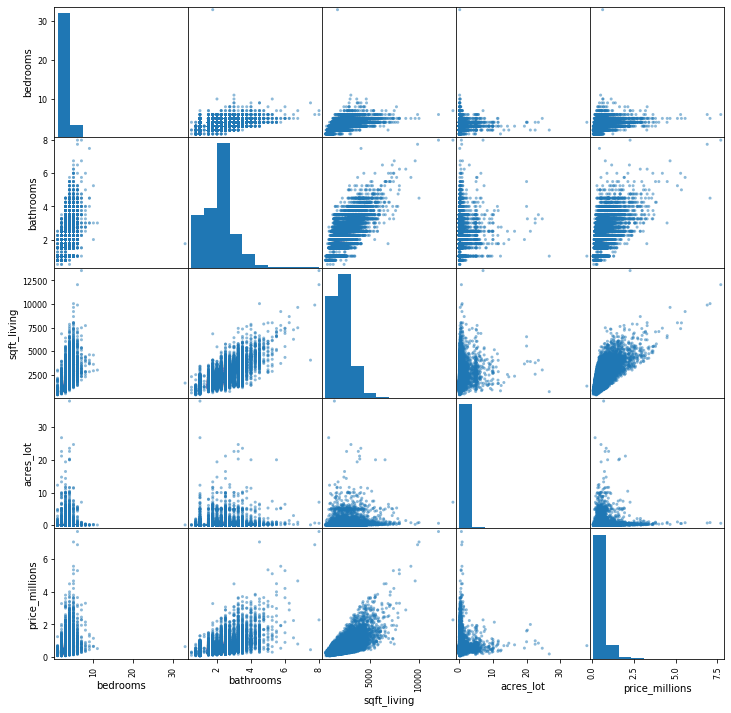

In [29]:
pd.plotting.scatter_matrix(df_scatter, figsize=(12,12))
plt.show()

## Waterfront-Price Density Histogram
Let's show another type of distribution now that we have "waterfront" column cleaned up

In [30]:
# Density histogram of house price - waterfront vs. non-waterfront:
water_df =  df.loc[df['waterfront'] == 1]
no_water_df =  df.loc[df['waterfront'] == 0]

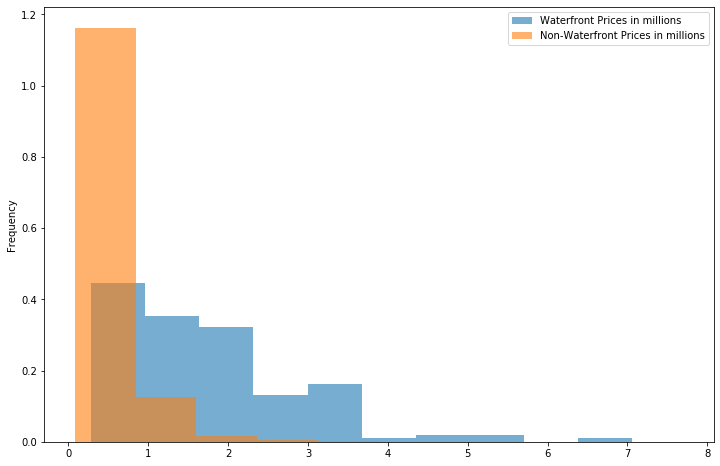

In [31]:
# Plot histograms (with densities on the y-axis) for waterfront and non-waterfront house prices:
plt.figure(figsize = (12,8))
binsize = 10
water_df.price_millions.plot.hist(bins = binsize, density = True,  alpha = 0.6, label ="Waterfront Prices in millions");
no_water_df.price_millions.plot.hist(bins = binsize, density = True, alpha = 0.6, label = 'Non-Waterfront Prices in millions');
plt.legend()
plt.show()


## Interpret Waterfront-Price Density Histogram
- Waterfront properties tend to have higher selling prices than non-waterfront properties
- Waterfront properties have a higher spread than non-watefront properties - that's why the waterfront peak is smaller than the non-waterfront peak
- Neither price distributions are normally distributed
- Waterfront and non-waterfront properties overlap in price from about .3-.7 million

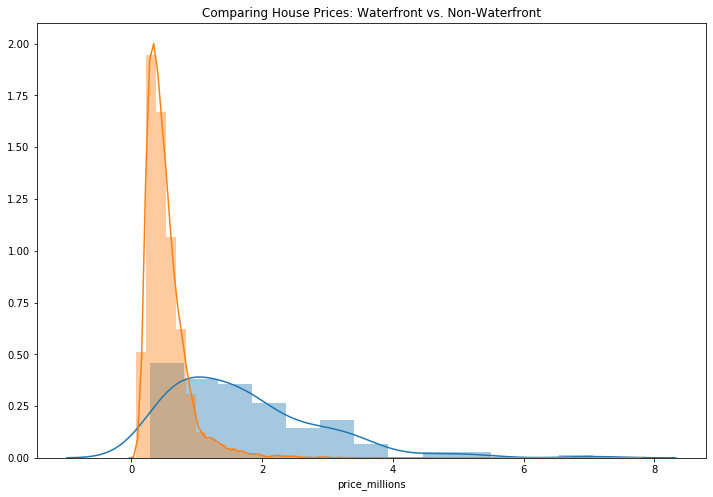

In [32]:
# Ok. Now let's draw a smooth curve, given the above data, using KDE (kernal density estimation)
# The smooth line in the visualization below is an estimate of the distributions of waterfront and non-waterfront house prices
# The parameter bandwidth rules the smoothness of the underlying distribution

# The problem with a Probability Density Function plot, is that all "point probabilities" are 0
# We must calculate the area under the curve for an interval to get the actual probability for an interval of house prices.
# Thus, it's not intuitive or easy to "read" the y-axis to get probabilities for continuous variables using a PDF like below.

plt.figure(figsize = (12,8))
sns.distplot(water_df.price_millions,kde=True)
sns.distplot(no_water_df.price_millions,kde=True)
plt.title('Comparing House Prices: Waterfront vs. Non-Waterfront')
plt.show()




For example, if we wanted to know the probability that a waterfront house price is between 2 and 4 million dollars (inclusive), we would use the following formula to take the integral of this range (AKA area under the curve)
$$\large P(2 \leq X \leq 4) = \int_{2}^{4} f_x(x) dx \geq 0 $$


## Price Density Histogram

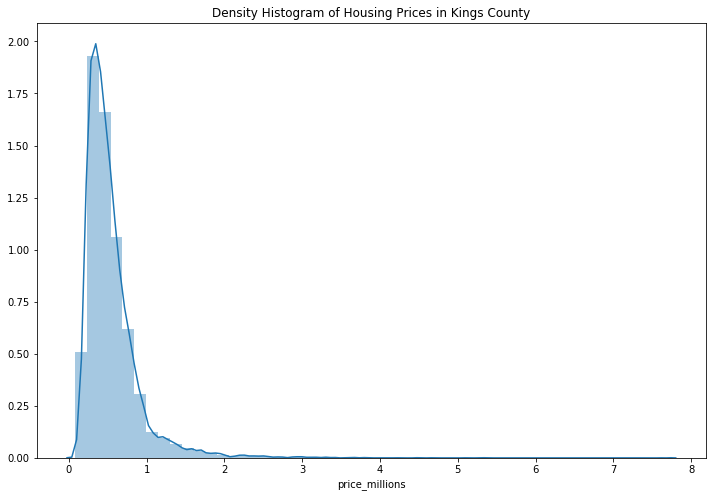

In [33]:
# From this we can see that generally, most houses are priced below one million dollars
plt.figure(figsize = (12,8))
sns.distplot(df.price_millions,kde=True)
plt.title('Density Histogram of Housing Prices in Kings County')
plt.show()

In [34]:
# Let's review what is in df:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,acres_lot,price_millions
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1955,0.129706,0.2219
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,1951,0.166253,0.5380
2,180000.0,2,1.00,770,10000,1.0,0,3,6,1933,0.229568,0.1800
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1965,0.114784,0.6040
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1987,0.185491,0.5100


In [35]:
# Create a Sensible df for modeling:
df_model = df.drop(['acres_lot', 'price'], axis=1)

In [47]:
df_model.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,price_millions
0,3,1.00,1180,5650,1.0,0,3,7,1955,0.2219
1,3,2.25,2570,7242,2.0,0,3,7,1951,0.5380
2,2,1.00,770,10000,1.0,0,3,6,1933,0.1800
3,4,3.00,1960,5000,1.0,0,5,7,1965,0.6040
4,3,2.00,1680,8080,1.0,0,3,8,1987,0.5100


### Normalize Numeric Data
-  The z-score normalization method is the most common
- If standard deviation is a yardstick, then a z-score is the measurement expressed in terms of that yardstick
- For example, if we find the z-score for a given x-value's distance from x-bar  divided by the standard deviation...
- We have convereted the distance of x from x-bar to "standard deviation units"
- If s = 30, then we want to see how many s's (quantities of 30) that x is from x-bar
- Basically, a z-score expresses each value of x as a standard unit away from the mean (x-bar)

In [67]:
# make copy of df_model for normalization purposes: 
df_scale = df_model.copy()

# Apply z-score normalization:
def z_score_norm(my_column):
    return (my_column - my_column.mean())/my_column.std()
for predictor in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition','grade','yr_built']:
    df_scale[predictor] = z_score_norm(df_scale[predictor])
# print normalized data: 
print(df_scale)

       bedrooms  bathrooms  sqft_living  sqft_lot    floors  waterfront  \
0     -0.402894  -1.451039    -0.980629 -0.228177 -0.915531   -0.082498   
1     -0.402894   0.174482     0.533357 -0.189735  0.937409   -0.082498   
2     -1.482459  -1.451039    -1.427201 -0.123137 -0.915531   -0.082498   
3      0.676671   1.149794    -0.131054 -0.243873 -0.915531   -0.082498   
4     -0.402894  -0.150622    -0.436030 -0.169499 -0.915531   -0.082498   
...         ...        ...          ...       ...       ...         ...   
21592 -0.402894   0.499586    -0.599410 -0.337298  2.790349   -0.082498   
21593  0.676671   0.499586     0.250165 -0.224241  0.937409   -0.082498   
21594 -1.482459  -1.776143    -1.154901 -0.332010  0.937409   -0.082498   
21595 -0.402894   0.499586    -0.523166 -0.306945  0.937409   -0.082498   
21596 -1.482459  -1.776143    -1.154901 -0.338626  0.937409   -0.082498   

       condition     grade  yr_built  price_millions  
0      -0.629972 -0.560787 -0.544665        

In [72]:
df_scale.sort_values('price_millions', ascending = False).head(10)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,price_millions
7245,2.835802,7.651878,10.858961,0.301855,1.863879,-0.082498,0.907199,4.553432,-2.076568,7.70
3910,1.756237,3.100419,8.669671,0.536686,0.937409,12.120968,-0.629972,2.848692,-1.055300,7.06
9245,2.835802,7.326773,8.506291,0.392986,0.937409,-0.082498,-0.629972,4.553432,1.021279,6.89
4407,1.756237,4.725940,7.754744,0.482210,0.937409,-0.082498,-0.629972,4.553432,1.021279,5.57
1446,1.756237,3.750628,6.447706,0.214562,0.937409,-0.082498,-0.629972,3.701062,1.293618,5.35
1313,2.835802,5.051044,5.783295,0.234943,0.937409,12.120968,0.907199,3.701062,0.680857,5.30
1162,1.756237,4.075732,6.458598,0.734500,0.937409,12.120968,-0.629972,3.701062,0.953195,5.11
8085,1.756237,6.026357,8.233992,-0.049053,-0.915531,12.120968,-0.629972,3.701062,0.408518,4.67
2624,1.756237,4.400836,4.966396,0.601618,0.937409,12.120968,-0.629972,3.701062,1.123406,4.50
8629,0.676671,1.149794,4.737664,0.299850,0.937409,-0.082498,-0.629972,3.701062,1.021279,4.49


In [73]:
df_model.sort_values('price_millions', ascending = False).head(10)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,price_millions
7245,6,8.00,12050,27600,2.5,0,4,13,1910,7.70
3910,5,4.50,10040,37325,2.0,1,3,11,1940,7.06
9245,6,7.75,9890,31374,2.0,0,3,13,2001,6.89
4407,5,5.75,9200,35069,2.0,0,3,13,2001,5.57
1446,5,5.00,8000,23985,2.0,0,3,12,2009,5.35
1313,6,6.00,7390,24829,2.0,1,4,12,1991,5.30
1162,5,5.25,8010,45517,2.0,1,3,12,1999,5.11
8085,5,6.75,9640,13068,1.0,1,3,12,1983,4.67
2624,5,5.50,6640,40014,2.0,1,3,12,2004,4.50
8629,4,3.00,6430,27517,2.0,0,3,12,2001,4.49


In [36]:
correlations = df_model.corr()

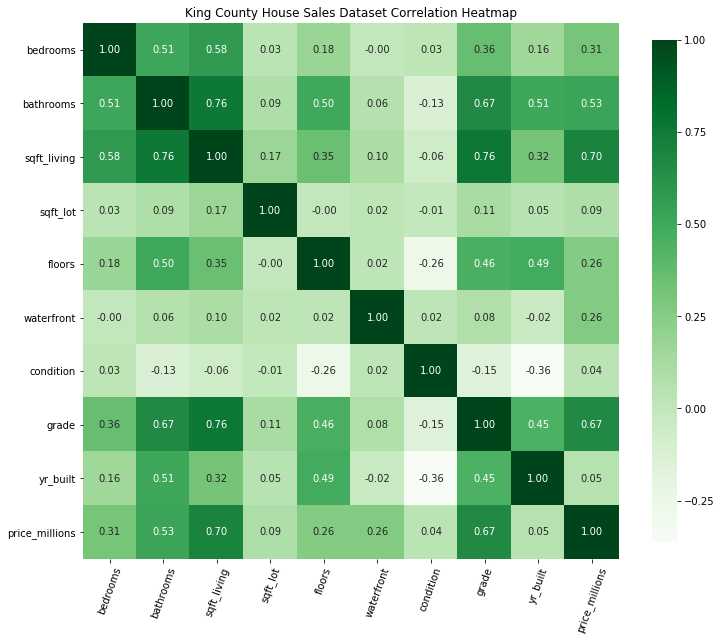

In [37]:
plt.figure(figsize=(12,12)) # Set size of figure
# Use df.corr() as your matrix for the heatmap
# I set the color scheme to green using cmap
# annot= True adds the float value on each square
# fmt='.1f' sets the number of decimal places for each float number. If you want 1.00, for example, use fmt='.2f'
# cbar_kws={"shrink": .77}  - this argument shrinks the side color bar to .77 of its original size
# square=True - this argument makes the figure square
ax = sns.heatmap(correlations, cmap = "Greens", annot=True, fmt='.2f', cbar_kws={"shrink": .77}, square=True)
# Sets the title
ax.set(title='King County House Sales Dataset Correlation Heatmap')
# Get the y-axis limit values for the size of the figure:
bottom, top = ax.get_ylim()
# Add .5 to the bottom and top of the y-axis limits to fix an error where the top and bottom squares are cut off
# This is an error for the versions of Seaborne and Matplotlib I'm using
ax = ax.set_ylim(bottom + 0.5, top - 0.5)
# Rotate the bottom labels by 30 degrees (100-70)
plt.xticks(rotation=70)
plt.show()


In [38]:
correlations["price_millions"].sort_values(ascending=False)

price_millions    1.000000
sqft_living       0.701917
grade             0.667951
bathrooms         0.525906
bedrooms          0.308787
waterfront        0.264306
floors            0.256804
sqft_lot          0.089876
yr_built          0.053953
condition         0.036056
Name: price_millions, dtype: float64

In [39]:
correlations["sqft_living"].sort_values(ascending=False)

sqft_living       1.000000
grade             0.762779
bathrooms         0.755758
price_millions    0.701917
bedrooms          0.578212
floors            0.353953
yr_built          0.318152
sqft_lot          0.173453
waterfront        0.104637
condition        -0.059445
Name: sqft_living, dtype: float64

## Multicollinearity
- If a column has a high VIF value, it may be prudent to drop it from the linear regression model

### The feature highest correlated with price is sqft_living

Text(0, 0.5, 'House Sale Price')

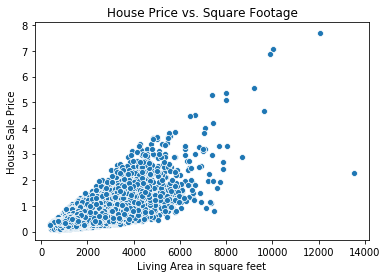

In [40]:
ax = sns.scatterplot(x="sqft_living", y="price_millions", data=df_model)
ax.set_title("House Price vs. Square Footage")
ax.set_xlabel("Living Area in square feet")
ax.set_ylabel("House Sale Price")



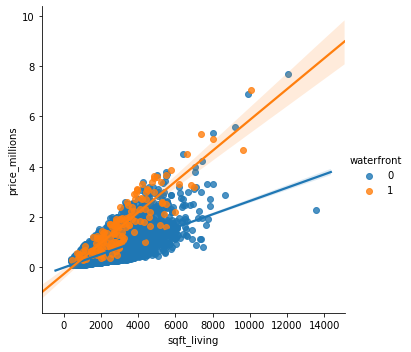

In [41]:
sns.lmplot(x="sqft_living", y="price_millions", data=df_model, hue="waterfront")


# MODELING
- Tune models to get the highest performance possible on our task
  - Considerations:
    - What kind of task? Classification task? Regression task?
    - Which models will we use
    - Will be use regularization?
    - How will we validate our model?
    - Loss functions?
    - What is the performance threshold for success?


## Linear Regression - Ordinary Least Squares

In [48]:
# Split normalized data into target variable and predictors/explanatory variables/independent variables
X = df_scale.drop('price_millions', axis=1) # independent variables
y = df_scale['price_millions'] # target variable

In [49]:
# Divide into test and train data
# Train data is for us to estimate our OLS model
# Test data is to parameterize our model, using that model to predict y values (price)
# If test_size = .3, that means 30% of our data is set aside for teh testing data
# And 70% of that data for training

# The parameter "random_state" ensures that if there is skew in our data, our 30-70 split is randomly taking from these groups
# So we have good proportions of randomly selected data and our 30-70 split has good representation 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)


In [50]:
# Linear Regressor - Ordinary Least Squares regression-type estimate:
lr = LinearRegression()

In [74]:
# Use Cross-validation to inspect model:
cvs = cross_val_score(estimator=lr, X=X_train, 
                                    y=y_train, 
                                    cv=10, scoring='r2')
print('CV score: %.3f ± %.3f' % (cvs.mean(), cvs.std()))

CV score: 0.640 ± 0.018


In [76]:
# Train model based on train dataset:
# Regressing the X's onto the y:
# We're getting a fit here, having used 70% of the data
lr.fit(X_train, y_train)
coef_list = list(lr.coef_)
name_list = list(X_train.columns)
pd.Series(coef_list, index=name_list)

bedrooms      -0.047497
bathrooms      0.041209
sqft_living    0.167322
sqft_lot      -0.011066
floors         0.010240
waterfront     0.060507
condition      0.010099
grade          0.150145
yr_built      -0.113141
dtype: float64

In [52]:
# Model prediction based on train dataset:
predict_y_train = lr.predict(X_train)

In [53]:
# Model Evaluation:
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.6418071120403939


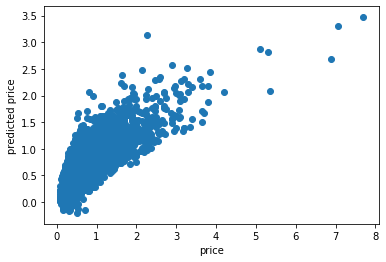

In [54]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price')
plt.ylabel('predicted price')
plt.show()

### Interpret price vs. predicted price scatterplot:
- The distribution isn't a straight line, and from that we know that there is something non-linear going on in the relationships we've modeled. 
- We don't have a good linear relationship between price and our predictors

Text(0, 0.5, 'residuals')

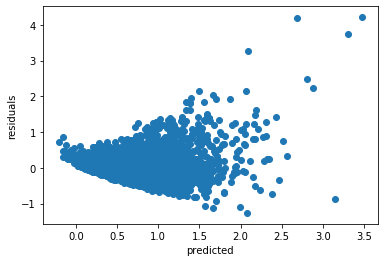

In [55]:
# Inspect the amount of error we got from our OLS Linear Regression:
# The residual is the amount of error in the estimation (difference between predicted and actual y values)
# The error is between .6 and -0.2, which is pretty wide

plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

Text(0, 0.5, 'frequency')

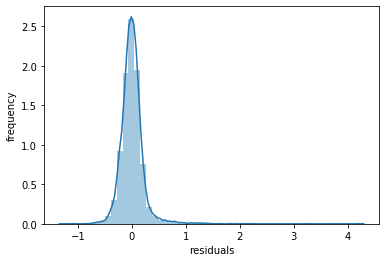

In [56]:
# Check Distribution of Errors:
# We can see from this that there's some right-skew to the distribution of error
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

### Interpretation of Regression Model
- We could remove outliers
- This is a very onerous and finicky process
- We might lose useful information if we pick out the outliers

In [57]:
# Finally, we take the 30% of that data we set aside for testing, and examine the error for that:
predict_y_test = lr.predict(X_test)
print('The R squared value is: ' + str(metrics.r2_score(y_test, predict_y_test)))



The R squared value is: 0.6530001064251156


In [58]:
# So looks like in-sample, out-of-sample is not as robust as we might want, 
# since our R-squared value is less than when using train data

## Random Forest Regressor - Decision Tree Regression-type Estimate

In [59]:
# Multiple Regression Trees are used
forest = RandomForestRegressor()

In [60]:
forest.fit(X_train, y_train)

/Users/clairesarraille/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [61]:
# Model prediction based on train dataset:
forest_predict_y_train = forest.predict(X_train)

In [62]:
# Model Evaluation:
print('The R squared value is: ' + str(metrics.r2_score(y_train, forest_predict_y_train)))

The R squared value is: 0.9448994364652239


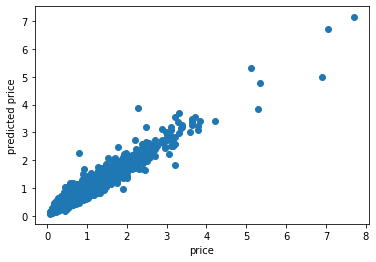

In [63]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, forest_predict_y_train)
plt.xlabel('price')
plt.ylabel('predicted price')
plt.show()

Text(0, 0.5, 'residuals')

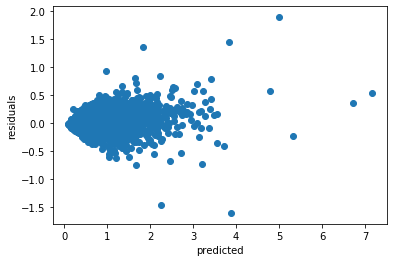

In [64]:
# Error from Random Forest Regressor:
# The error is between .20 and -0.15, which is better than it was for OLS Regression 

plt.scatter(forest_predict_y_train, y_train - forest_predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

In [65]:
# We've done in-sample for Random Forest, now let's do out of sample:
forest_predict_y_test = forest.predict(X_test)

In [66]:
# Model Evaluation:
print('The R squared value is: ' + str(metrics.r2_score(y_test, forest_predict_y_test)))

The R squared value is: 0.7036442724427945


### Interpretation of R Squared value from above:
- Going from .945 for the traning data (in-sample) to .700 for the test data (out of sample)
- That's a pretty steep difference
- This means that our model is not robust
- However, our model is still performing relatively well
